In [69]:
import pandas as pd
import numpy as np
import networkx as nx
import os

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
base = os.path.dirname(os.getcwd())
stats_path = os.path.join(base, 'csv files', 'For_Stats.csv')

stats_df = pd.read_csv(stats_path)

In [71]:
judges_higher = (stats_df.groupby('judge_name')['goe_dist'].mean().sort_values(ascending=False).head(10))
judges_higher


judge_name
Patricia MORITZ     0.605322
Patty KLEIN         0.384196
Karin EHRHARDT      0.347382
Elizabeth RYAN      0.331719
Soo Kyung LEE       0.331034
Veronique VERRUE    0.328975
Senem AHISKAL       0.297650
Slobodan DELIC      0.292398
Samuel AUXIER       0.277533
Pekka LESKINEN      0.275676
Name: goe_dist, dtype: float64

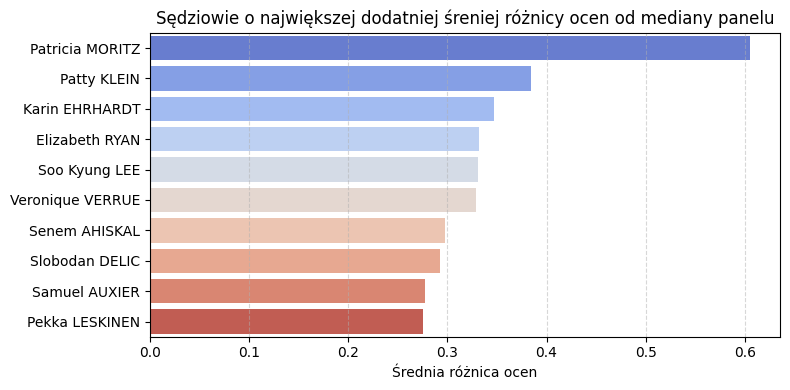

In [72]:
plt.figure(figsize=(8, 4))
sns.barplot(x=judges_higher.values, y=judges_higher.index, palette='coolwarm', hue=judges_higher.index)

plt.title('Sędziowie o największej dodatniej śreniej różnicy ocen od mediany panelu')
plt.ylabel('')
plt.xlabel('Średnia różnica ocen')

plt.tight_layout()
plt.grid(axis='x',  linestyle='--', alpha=0.5)
plt.show()

In [73]:
judges_lower = stats_df.groupby('judge_name')['goe_dist'].mean().sort_values(ascending=True).head(10)
judges_lower

judge_name
Jia YAO            -0.474097
Leslie KEEN        -0.443359
Lisa DAVIDSON      -0.430884
Kari-Anne OLSEN    -0.376000
Lisa JELINEK       -0.364444
Anne CAMMETT       -0.358586
Young Kyung HAN    -0.350694
Ursula STAHL       -0.345938
Elisabeth BINDER   -0.307692
Ron CONACHER       -0.291339
Name: goe_dist, dtype: float64

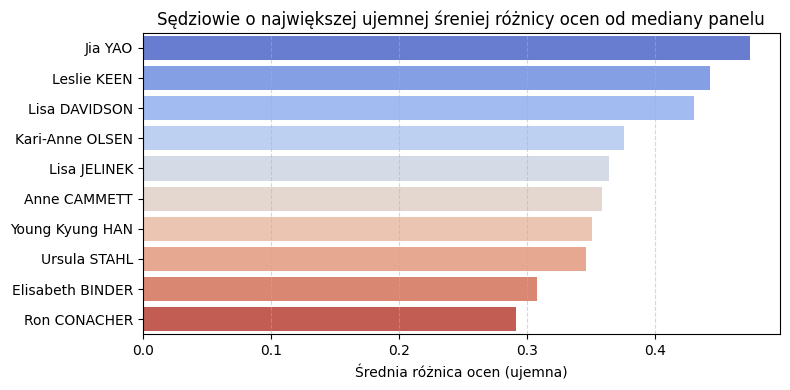

In [74]:
plt.figure(figsize=(8, 4))
sns.barplot(x=judges_lower.values * -1, y=judges_lower.index, palette='coolwarm', hue=judges_lower.index)

plt.title('Sędziowie o największej ujemnej śreniej różnicy ocen od mediany panelu')
plt.ylabel('')
plt.xlabel('Średnia różnica ocen (ujemna)')

plt.tight_layout()
plt.grid(axis='x',  linestyle='--', alpha=0.5)
plt.show()

In [75]:
grouped_same = stats_df.groupby('is_same')['goe_dist'].agg(['mean', 'median', 'std', 'count'])
grouped_same

,mean,median,std,count
is_same,,,,
0,-0.026740,0.0,0.757220,193531
1,0.150236,0.0,0.725521,16088


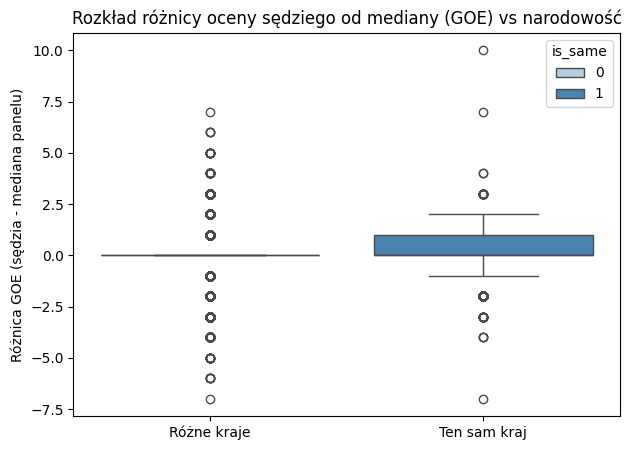

In [76]:
sns.boxplot(x='is_same', y='goe_dist', data=stats_df, palette='Blues', hue='is_same')
plt.xticks([0, 1], ['Różne kraje', 'Ten sam kraj'])
plt.title('Rozkład różnicy oceny sędziego od mediany (GOE) vs narodowość')
plt.xlabel(' ')
plt.ylabel('Różnica GOE (sędzia - mediana panelu)')
plt.tight_layout()
plt.show()

In [77]:
same_country = stats_df[stats_df['is_same'] == 1]

bias_nation = same_country.groupby('judge_nation')['goe_dist'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
bias_nation_f = bias_nation[bias_nation['count'] > 50]

bias_nation_f

,mean,count
judge_nation,,
HKG,0.382716,81
ISR,0.266187,139
UKR,0.264151,53
SWE,0.261111,180
FRA,0.258654,1040
BUL,0.234375,64
RUS,0.231771,1152
KOR,0.230705,1192
GEO,0.208029,274


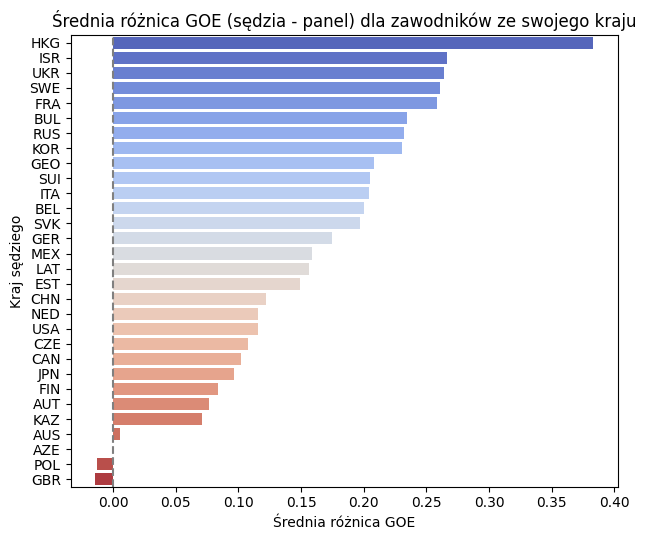

In [78]:
plt.figure(figsize=(6.5, 5.5))
sns.barplot(x=bias_nation_f['mean'], y=bias_nation_f.index, palette='coolwarm', hue=bias_nation_f.index)
plt.title('Średnia różnica GOE (sędzia - panel) dla zawodników ze swojego kraju')
plt.xlabel('Średnia różnica GOE')
plt.ylabel('Kraj sędziego')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [79]:
country_bias_matrix = stats_df.pivot_table(
    index='judge_nation',
    columns='nation',
    values='goe_dist',
    aggfunc='mean'
)

count_matrix = stats_df.pivot_table(
    index = 'judge_nation',
    columns = 'nation',
    values = 'goe_dist',
    aggfunc = 'count'
)

country_bias_matrix_f = country_bias_matrix.where(count_matrix > 50)

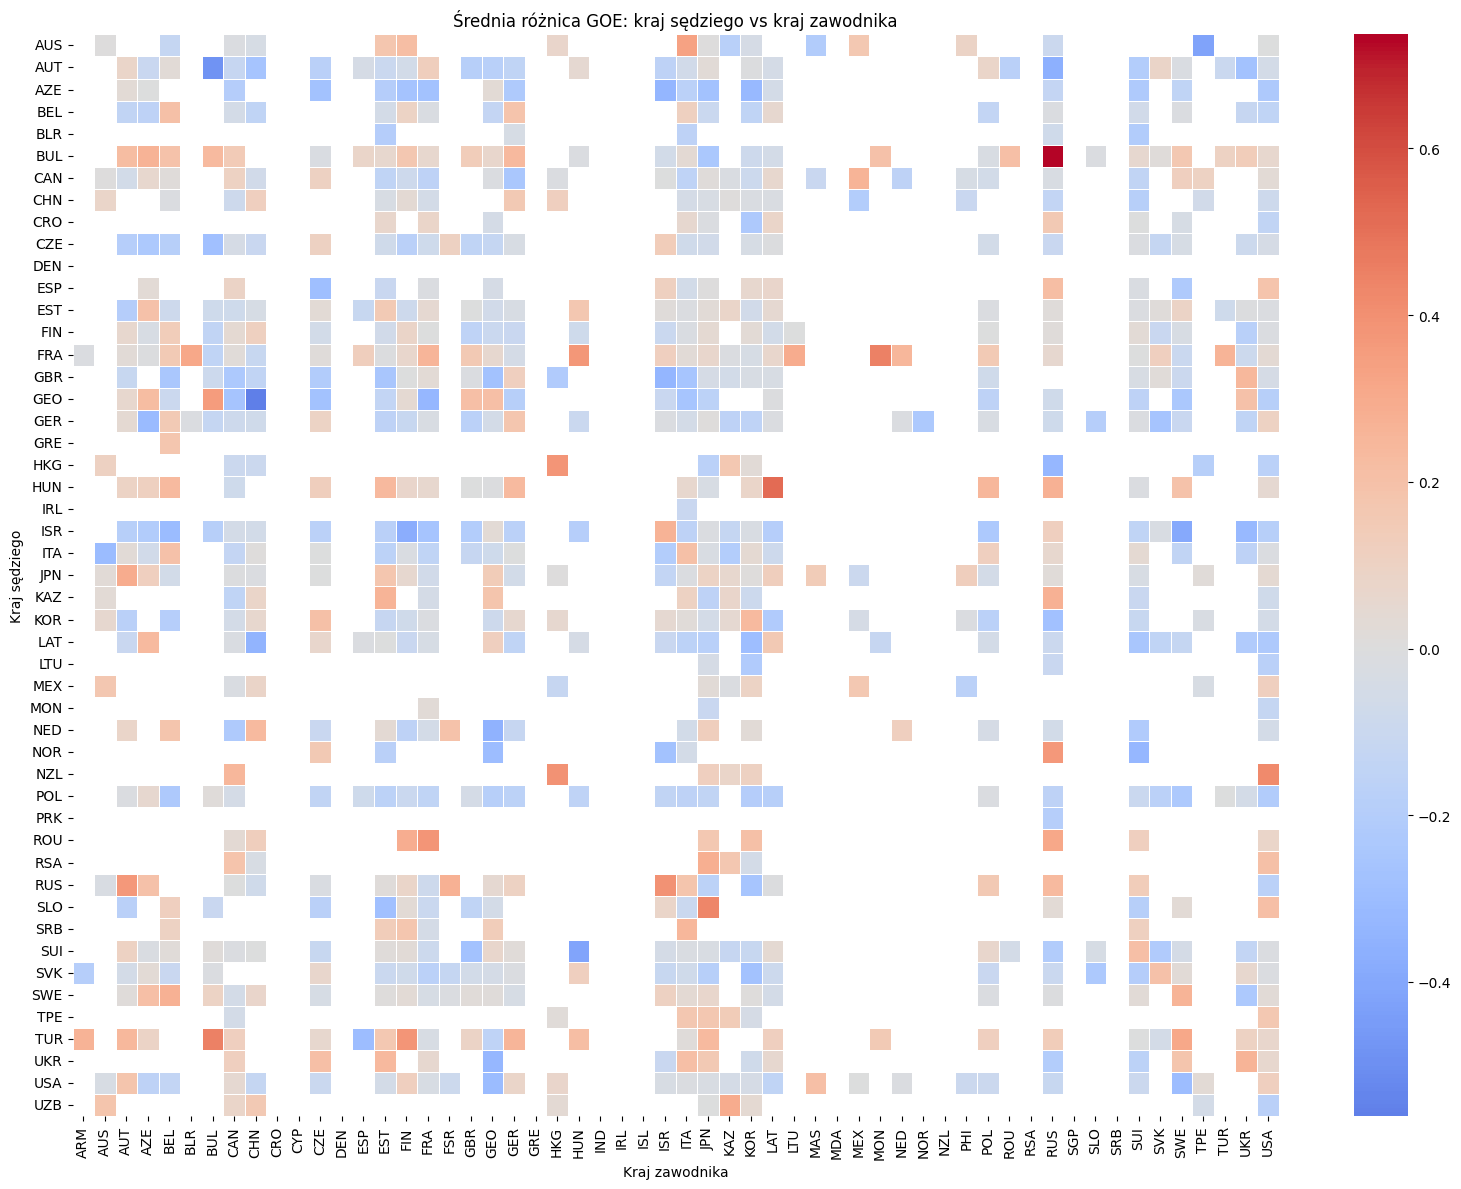

In [80]:
plt.figure(figsize=(16, 12))
sns.heatmap(country_bias_matrix_f, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title('Średnia różnica GOE: kraj sędziego vs kraj zawodnika')
plt.xlabel('Kraj zawodnika')
plt.ylabel('Kraj sędziego')
plt.tight_layout()
plt.show()

In [81]:
bias_long = country_bias_matrix_f.stack().reset_index()
bias_long.columns = ['judge_nation', 'nation', 'mean_goe_dist']

bias_long['count'] = count_matrix.stack().reindex(pd.MultiIndex.from_frame(bias_long[['judge_nation', 'nation']])).values

top_favor = bias_long.sort_values('mean_goe_dist', ascending=False).head(10)
top_penalize = bias_long.sort_values('mean_goe_dist').head(10)

top_favor, top_penalize

(    judge_nation nation  mean_goe_dist  count
 111          BUL    RUS       0.736842   57.0
 414          HUN    LAT       0.522222   90.0
 791          TUR    BUL       0.452830   53.0
 300          FRA    MON       0.450980   51.0
 688          SLO    JPN       0.436364   55.0
 612          NZL    USA       0.421875   64.0
 668          RUS    ISR       0.394366   71.0
 608          NZL    HKG       0.392157   51.0
 644          ROU    FRA       0.386667   75.0
 796          TUR    FIN       0.384615   78.0,
     judge_nation nation  mean_goe_dist  count
 340          GEO    CHN      -0.561404   57.0
 20           AUT    BUL      -0.480519   77.0
 15           AUS    TPE      -0.422222   90.0
 713          SUI    HUN      -0.418182   55.0
 445          ISR    SWE      -0.392523  107.0
 429          ISR    FIN      -0.378378   74.0
 39           AUT    RUS      -0.367857  280.0
 590          NED    GEO      -0.350877   57.0
 541          LAT    CHN      -0.345794  107.0
 55         

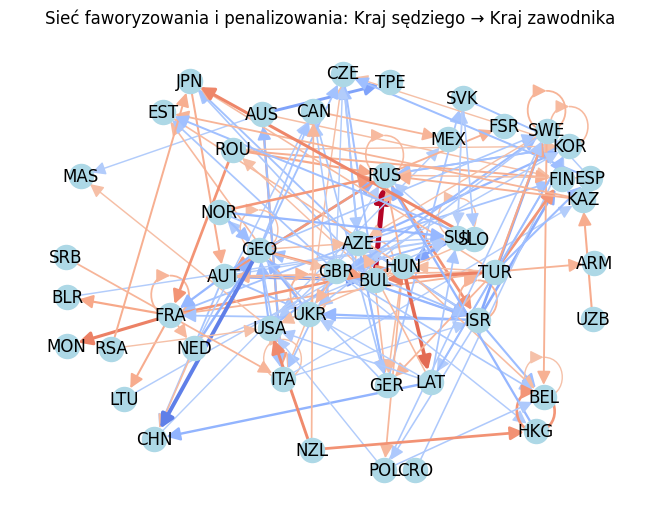

In [82]:
G = nx.DiGraph()

threshold = 0.2
max_bias = country_bias_matrix_f.abs().max().max() 

cmap = plt.get_cmap("coolwarm")

for judge in country_bias_matrix_f.index:
    for athlete in country_bias_matrix_f.columns:
        bias = country_bias_matrix_f.loc[judge, athlete]
        if pd.notna(bias) and abs(bias) >= threshold:
            norm_bias = (bias + max_bias) / (2 * max_bias)
            color = cmap(norm_bias)
            G.add_edge(judge, athlete, weight=abs(bias), color=color)

pos = nx.spring_layout(G, k=0.8, seed=42)

edges = G.edges(data=True)
colors = [attr['color'] for _, _, attr in edges]
weights = [attr['weight'] * 5 for _, _, attr in edges]


nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=colors, width=weights, arrowsize=20)
plt.title('Sieć faworyzowania i penalizowania: Kraj sędziego → Kraj zawodnika')
plt.show()

## Marking Score

In [83]:
stats_df

,rank,competition,name,nation,startnr,total,tech,pcs,deductions,element,...,judge_nation,judge_goe,panel_median,is_same,goe_dist,higher,lower,pt_bias,s_progression,prestige
0,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,4S+2T,...,GEO,1.0,2.0,0,-1.0,0,1,0,0.54,0.06
1,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,3F,...,GEO,2.0,3.0,0,-1.0,0,1,0,0.54,0.06
2,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,FSSp4,...,GEO,3.0,3.0,0,0.0,0,0,0,0.54,0.06
3,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,3A,...,GEO,3.0,3.0,0,0.0,0,0,0,0.54,0.06
4,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,StSq4,...,GEO,2.0,4.0,0,-2.0,0,1,0,0.54,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209614,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,2A+2T,...,FRA,0.0,0.0,0,0.0,0,0,0,0.67,0.00
209615,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,3Sq+2T,...,FRA,-5.0,-5.0,0,0.0,0,0,0,0.67,0.00
209616,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,LSp2,...,FRA,-1.0,1.0,0,-2.0,0,1,0,0.67,0.00
209617,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,StSq3,...,FRA,-2.0,0.0,0,-2.0,0,1,0,0.67,0.00


In [84]:
error_level = stats_df.groupby('panel_median')['goe_dist'].agg(
    mean_error = lambda x: round((x**2).mean()**0.5, 2), 
    count = 'count')

error_level

,mean_error,count
panel_median,,
-5.0,0.32,12735
-4.0,0.81,3636
-3.0,0.81,6282
-2.0,0.79,8892
-1.0,0.84,10395
0.0,0.84,21978
1.0,0.80,43506
2.0,0.75,60759
3.0,0.72,33516


In [85]:
x = error_level.index.values  
y = error_level['mean_error'].values

def exp_func(l, a, b):
    return a * np.exp(-b * np.abs(l))

params, _ = curve_fit(exp_func, x, y, bounds=([0, 0], [np.inf, np.inf]))
a, b = params

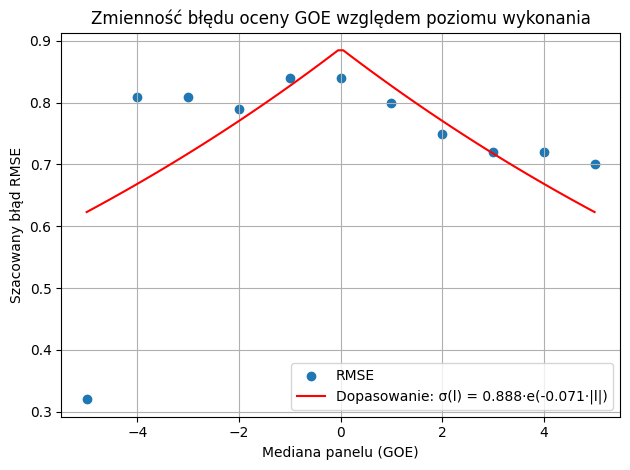

In [86]:
plt.scatter(x, y, label='RMSE')
x_fit = np.linspace(min(x), max(x), 100)
y_fit = exp_func(x_fit, a, b)
plt.plot(x_fit, y_fit, color='red', label=f'Dopasowanie: σ(l) = {a:.3f}·e(-{b:.3f}·|l|)')
plt.xlabel('Mediana panelu (GOE)')
plt.ylabel('Szacowany błąd RMSE')
plt.title('Zmienność błędu oceny GOE względem poziomu wykonania')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
error_levels_d = {}

for i in range(len(error_level)):
    error_levels_d[error_level.index[i]] = error_level['mean_error'].iloc[i]

error_levels_d

{np.float64(-5.0): np.float64(0.32),
 np.float64(-4.0): np.float64(0.81),
 np.float64(-3.0): np.float64(0.81),
 np.float64(-2.0): np.float64(0.79),
 np.float64(-1.0): np.float64(0.84),
 np.float64(0.0): np.float64(0.84),
 np.float64(1.0): np.float64(0.8),
 np.float64(2.0): np.float64(0.75),
 np.float64(3.0): np.float64(0.72),
 np.float64(4.0): np.float64(0.72),
 np.float64(5.0): np.float64(0.7)}

In [91]:
stats_df['rmse_for_level'] = stats_df.apply(
    lambda row: error_levels_d.get(row['panel_median']), 
    axis=1
)

stats_df['marking_score'] = stats_df.apply(
    lambda row: round(abs(row['goe_dist']) / row['rmse_for_level'], 2),
    axis=1
)

stats_df

,rank,competition,name,nation,startnr,total,tech,pcs,deductions,element,...,panel_median,is_same,goe_dist,higher,lower,pt_bias,s_progression,prestige,rmse_for_level,marking_score
0,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,4S+2T,...,2.0,0,-1.0,0,1,0,0.54,0.06,0.75,1.33
1,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,3F,...,3.0,0,-1.0,0,1,0,0.54,0.06,0.72,1.39
2,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,FSSp4,...,3.0,0,0.0,0,0,0,0.54,0.06,0.72,0.00
3,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,3A,...,3.0,0,0.0,0,0,0,0.54,0.06,0.72,0.00
4,1,ec2020SEG001OF,Michal BREZINA,CZE,26,89.77,48.05,41.72,0.0,StSq4,...,4.0,0,-2.0,0,1,0,0.54,0.06,0.72,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209614,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,2A+2T,...,0.0,0,0.0,0,0,0,0.67,0.00,0.84,0.00
209615,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,3Sq+2T,...,-5.0,0,0.0,0,0,0,0.67,0.00,0.32,0.00
209616,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,LSp2,...,1.0,0,-2.0,0,1,0,0.67,0.00,0.80,2.50
209617,24,wc2025SEG004OF,Meda VARIAKOJYTE,LTU,1,88.83,48.22,40.61,0.0,StSq3,...,0.0,0,-2.0,0,1,0,0.67,0.00,0.84,2.38


In [96]:
stats_df.groupby('judge_name')['marking_score'].agg(
    jugde_marking_score = lambda row: round(np.sqrt(((row**2).sum()).mean()), 2)
)

,jugde_marking_score
judge_name,
Adrienn SCHADENBAUER,18.14
Agita ABELE,53.37
Agnieszka SWIDERSKA,31.97
Akiko KOBAYASHI,26.02
Akos PETHES,16.97
...,...
Yuriy GUSKOV,41.50
Yury KLIUSHNIKOV,55.40
Zanna KULIK,37.88
